<a href="https://colab.research.google.com/github/Rogerio-mack/fNIRS/blob/main/MB01_rectify_snirf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retifica todos arquivos `.snirf` para o projeto MB
---

**Entrada:**

> * Um diretório com arquivos `.snirf` 
>> *Foram processados os arquivos da condição 1 e da condição 2 do experimento da Luva de Borracha*

**Saída:**

> * Cria um subdiretório `\snirf` no diretório original com os arquivos retificados

>> Faz as seguintes alterações criando novos arquivos `.snirf` (dentre outros, ajustes requeridos para uso no `NME-nirs`):

>> * Inclui registro AppName b'snirf-Mack' para identificar os dados tratados nos arquivos
>> * POSITIVA os canais com sinais < 0
>> * Ajusta `time` para intervalos de tempo constante
>> * Valida a carga dos dados com o `NME-nirs`
>> * Cria no diretório de entrada um diretório `/snirf` com os arquivos alterados
>> * Split dos estímulos 3x8 = 24
>> * Elimina os casos inválidos como por exemplo com falta de evento de estímulos ou ainda com estímulos com marcação errada


## Install & import `nilearn` and `mne-nirs`

In [ ]:
#@markdown
!pip install nilearn
!pip install -U --no-deps https://github.com/mne-tools/mne-python/archive/main.zip
!pip install mne-nirs

from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne 



     |████████████████████████████████| 9.6 MB 23.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.7 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     | 61.5 MB 158 kB/s
  Created wheel for mne: filename=mne-1.1.dev0-py3-none-any.whl size=7422442 sha256=36221598d917da9fec897a85da1d22a6f250191273867b90f7dcdcf4703df9e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-vhrc0vgi/wheels/66/fc/d2/9d32190e71b475f1cabf28474c2cbc9274afb98ff6fa2dc7fd
Successfully built mne
     |████████████████████████████████| 93 kB 1.7 MB/s 


## Mount Google Drive

In [ ]:
#@markdown
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Common Imports

In [ ]:
#@markdown 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

import h5py
from itertools import compress
from sklearn.preprocessing import scale
from google.colab import widgets

## Routines

In [ ]:
#@markdown `def clone_snirf(path_in, path_out, fname='out.snirf')`
def clone_snirf(path_in, path_out, fname='out.snirf'):
  
  if path_in == path_out:
    print('Error: path_in and path_out can not be the same.') 
    return

  if not os.path.exists(path_out):
      os.mkdir(path_out)
      print("Directory " , path_out ,  "was created")
  else:    
      print("Warning: directory " , path_out ,  " already exists")

  if os.path.exists(path_out + fname):
    os.remove(path_out + fname)
    print('Warning: previous output file was deleted.')
  
  print('Input snirf file: ' + path_in + fname)

  fs = h5py.File(path_in + fname,'r')
  fd = h5py.File(path_out + fname,'w')

  if list(fs.keys()).count('formatVersion') >= 1:
    fs.copy('formatVersion',fd,'formatVersion') 
  else:
    print('Warning: there is no formatVersion key in snirf input.')

  if list(fs.keys()).count('nirs') >= 1:
    fs.copy('nirs',fd,'nirs') 
  else:
    print('Error: Invalid snirf file. There is no nirs key in snirf input.')  
  
  print('Output snirf file: ' + path_out + fname)
  
  fd.close()
  fs.close()

  return

In [ ]:
#@markdown `def create_channels_table(data,reorder=False)`
def create_channels_table(data,reorder=False):

  if reorder:
    print('Warning: reorder=True puts channels names in ascendent order, but this can be a different order from snirf file.')

  # Parameters: 
  # data: snirf file read

  # create alias for all data['nirs'].keys()
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
    print(exp)
    exec(exp)
    
  nr_measurements = len([ x for x in list( data1.keys() ) if 'measurementList' in x ])+1
  measurements = ['measurementList' + str(x) for x in np.arange(1,nr_measurements)] 
  # print(measurements)

  measure_idx = []
  name = []
  source =  []
  detector = []
  source_pos = []
  detector_pos = []
  source_pos_3D = []
  detector_pos_3D = []
  flag_2D = True
  flag_3D = True
  frequencies = []

  for m in measurements:
    measure_idx.append( int( m[ len('measurementList'):: ] ) )
    
    e_name = probe['sourceLabels'][ int(data1[m]['sourceIndex'][0]) - 1 ].decode('UTF-8') + '_' + probe['detectorLabels'][ int(data1[m]['detectorIndex'][0]) - 1 ].decode('UTF-8') 
    e_source = int(data1[m]['sourceIndex'][0])   
    e_detector = int(data1[m]['detectorIndex'][0]) 
    
    if list(probe.keys()).count('sourcePos2D') > 0 and list(probe.keys()).count('detectorPos2D') > 0: 
      e_source_pos = probe['sourcePos2D'][ int(data1[m]['sourceIndex'][0]) - 1 ] # .decode('UTF-8')
      e_detector_pos = probe['detectorPos2D'][ int(data1[m]['detectorIndex'][0]) - 1 ] # .decode('UTF-8')
    else:
      flag_2D = False
      e_source_pos = e_detector_pos = np.array([0,0],dtype=float)

    # e_frequencies = probe['frequencies'][0]

    if list(probe.keys()).count('sourcePos3D') > 0 and list(probe.keys()).count('detectorPos3D') > 0:
      e_source_pos_3D = probe['sourcePos3D'][ int(data1[m]['sourceIndex'][0]) - 1 ] # .decode('UTF-8')
      e_detector_pos_3D = probe['detectorPos3D'][ int(data1[m]['detectorIndex'][0]) - 1 ] # .decode('UTF-8')
    else:
      flag_3D = False
      e_source_pos_3D = e_detector_pos_3D = np.array([0,0,0],dtype=float)

    name.append( e_name )
    source.append( e_source )
    detector.append( e_detector )
    source_pos.append( e_source_pos )
    detector_pos.append( e_detector_pos )
  #  frequencies.append( e_frequencies )
    source_pos_3D.append( e_source_pos_3D )
    detector_pos_3D.append( e_detector_pos_3D )

  if not flag_2D:
    print('WARNING: no source, detector pos 2D available\n')

  if not flag_3D:
    print('WARNING: no source, detector pos 3D available\n')

  # print(measure_idx)  
  # print(name)  
  # print(source)
  # print(detector)
  # print(source_pos)
  # print(detector_pos)
  # print(frequencies)
  # print(source_pos_3D)
  # print(detector_pos_3D)

  measures = pd.DataFrame({'measure_idx':measure_idx,
                          'name':name,
                          'source':source,
                          'detector':detector,
  #                         'frequencies':frequencies,
                          'source_pos':source_pos,
                          'detector_pos':detector_pos,
                          'source_pos_3D':source_pos_3D,
                          'detector_pos_3d':detector_pos_3D}) # .sort_values('measure_idx').reset_index(drop=True)
  # measures.head()

  wavelength = []

  for m in measurements:
    wavelength.append( str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ])) )
  #  print( m,str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ]))  )

  # wavelength
  measures['wavelength'] = wavelength 
  measures['name'] = measures['name'] + '_' + wavelength 
  measures.set_index('measure_idx',inplace=True) 

  measures = measures[['name', 'source', 'detector', 'wavelength', 'source_pos', 'detector_pos',
        'source_pos_3D', 'detector_pos_3d']]
  measures = measures.rename_axis('')
  measures.head()

  if reorder:
    measures = measures.sort_values('name')

  return measures.reset_index(drop=True)




In [ ]:
#@markdown `def create_channels_raw(data,reorder=False)`
def create_channels_raw(data,reorder=False):

  # Parameters: 
  # data: snirf file read

  if reorder:
    print('Warning: reorder=True puts channels names in ascendent order, but this can be a different order from snirf file.')

  # create alias for all data['nirs'].keys()
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
    exec(exp)

  nr_measurements = len([ x for x in list( data1.keys() ) if 'measurementList' in x ])+1
  measurements = ['measurementList' + str(x) for x in np.arange(1,nr_measurements)] 

  measure_idx = []
  name = [] 
  for m in measurements:
    measure_idx.append( int( m[ len('measurementList'):: ] ) )
    e_name = probe['sourceLabels'][ int(data1[m]['sourceIndex'][0]) - 1 ].decode('UTF-8') + '_' + probe['detectorLabels'][ int(data1[m]['detectorIndex'][0]) - 1 ].decode('UTF-8') 
    name.append( e_name )

  measures = pd.DataFrame({'name':name})

  wavelength = []

  for m in measurements:
    wavelength.append( str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ])) )
  #  print( m,str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ]))  )

  measures['name'] = measures['name'] + '_' + wavelength 

  # print(measures)

  raw = pd.concat([pd.DataFrame(data1['time']), pd.DataFrame(data1['dataTimeSeries'])], axis=1)
  raw.columns = ['time'] + list(measures.name) 
  
  if reorder:
    df_temp = raw.drop(columns='time')
    df_temp = df_temp.reindex(sorted(df_temp.columns), axis=1)
    df_temp = pd.concat([raw.time,df_temp], axis=1 )
    raw = df_temp 

  return raw

In [ ]:
#@markdown `def normalize_channels(df)`
def normalize_channels(df):
  df_scaled = df.drop(columns='time').copy()
  
  for c in df_scaled:
    df_scaled[c] = scale( df_scaled[c] )

  df_scaled = pd.concat([df.time,df_scaled],axis=1)
  return df_scaled 

# normalize_channels(channels_raw)

In [ ]:
#@markdown `def plotchannels_all(df, reds=True, normalize=False, figsize=(20,16), cv_threshold=0.25)`
def plotchannels_all(df, reds=True, normalize=False, figsize=(20,16), cv_threshold=0.25):

  f = plt.figure( figsize=figsize )

  if normalize:
    df_not_scaled = df.copy()
    df = normalize_channels(df)
  else:
    df_not_scaled = df # the same

  inicio = 0  
  inc = 6
  add_inc = 0
  ticks = []

  col_order = df.drop(columns='time').columns.sort_values()

  for c in col_order:
    if not reds:
      sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc )
    else:
      if df_not_scaled[c].min() < 0:
        sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc, color='r', alpha=0.8)
      else:
        if df_not_scaled[c].mean() != 0:
          cv = df_not_scaled[c].std() / df_not_scaled[c].mean()
        else:
          cv = 0
        sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc, color=['gray','yellow'][cv > cv_threshold or cv == 0], alpha=[0.5,0.8][cv > cv_threshold or cv == 0])

    ticks.append(inicio + add_inc)
    add_inc = add_inc + inc
    
  ylim = f.gca().get_ylim()[1]

  # for c in group_nirs['group']['stimulus'].drop(columns='time'):
  #  plt.plot(stimulus['time'],stimulus[c]*ylim,label=c,lw=1,linestyle='dashed')

  # plt.legend()
  if normalize:
    plt.yticks(ticks = ticks, labels = list( col_order ))
    plt.ylabel('')
  else:
    plt.ylabel('Channel Values')

  plt.show()

  return 

# plotchannels_all(channels_raw)
# plotchannels_all(channels_raw,normalize=True,figsize=(10,10))


In [ ]:
#@markdown `def check_sample_rate(df)`
def check_sample_rate(df):

  sample_rate = np.float(df.time[-1:] / len(df.time))
  print('Sample rate: ', sample_rate, 'in sec.')

  total_time =  df.time[-1:].values[0]
  print('Total time: ',   total_time , 'in sec.')

  resample = None 

  if not all( channels_raw.time.diff()[1::]*10 == channels_raw.time.diff()[1]*10 ):
    print('Warning: time seems have different intervals. For better signal processing sample rate should be constant. Try to check and correct this.')
    print('Sample rate suggested: 0.1 sec (for this, you can use time values of the third return of this function)')

    resample_time = np.round( np.arange(0,len(df),1)/10 , 1)

  return sample_rate, total_time, resample_time

# sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

# to change...
# channels_raw.time = resample_time
# sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

In [ ]:
#@markdown `def perc_negatives(s_neg)`
def perc_negatives(s_neg):
#
# Parameters:
# s_neg: np.array with negatives values
#
# Returns:
# perc_neg: % of negatives values
#
# Test:
# perc_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))
#
  return len( np.array(np.where( s_neg < 0 )).ravel() ) / len(s_neg)

# perc_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))

# channels_raw.drop(columns='time').apply(perc_negatives) 

In [ ]:
#@markdown `def plotchannels_tab(df, reds=False, threshold_neg = 0.10, all=True, normalized=True, statistics=True, individuals=True,  cv_threshold=0.25)`
# from matplotlib import pylab
from google.colab import widgets

def plotchannels_tab(df, reds=False, threshold_neg = 0.10, all=True, normalized=True, statistics=True, individuals=True,  cv_threshold=0.25):

  chnames = df.drop(columns='time').columns.sort_values()

  if individuals:
    tabnames = chnames.to_list()

    # Mark tabnames with '()' for channels with negative values
    for i in range(len(tabnames)):
      if df[ tabnames[i] ].min() < 0:
        tabnames[i] = '(' + tabnames[i] + ')'
  else:
    tabnames = []

  # Add other tabs
  before = 0
  
  if normalized:
    tabnames = ['Normalized'] + tabnames 
    before = before + 1

  if all:
    tabnames = ['All'] + tabnames 
    before = before + 1

  if statistics:
    tabnames = tabnames + ['Statistics']

  tb = widgets.TabBar(tabnames)

  if all:
    with tb.output_to(tabnames.index('All')):
      plotchannels_all(df,reds=True)

  if normalized:
    with tb.output_to(tabnames.index('Normalized')):
      plotchannels_all(df,reds=True,normalize=True)

  if individuals:
    for i in range(len(chnames)):
      # Only select the first 2 tabs, and render others in the background.
      with tb.output_to(i+before, select=(i+before < before)): # +2 because ['All','Normalized']
        if reds:
          if df[chnames[i]].min() < 0:          
            plt.plot(df.time, df[chnames[i]], color=['blue','red'][df[chnames[i]].min() < 0] )
          else:
            if df[chnames[i]].mean() != 0:
              cv = df[chnames[i]].std() / df[chnames[i]].mean()
            else:
              cv = 0  
            plt.plot(df.time, df[chnames[i]], color=['blue','yellow'][cv > cv_threshold or cv == 0] )
        else:
          plt.plot(df.time, df[chnames[i]], color='blue')

  if statistics:
    with tb.output_to(tabnames.index('Statistics'),select=0):
      display( df.drop(columns='time').describe() )
      print()

      neg_true = df.drop(columns='time').apply(min) < 0  

      if any(neg_true):
        print('Warning: There are negative values in signals.')

      for c in neg_true[ neg_true == True ].index:
        if perc_negatives(df[c]) > threshold_neg:
          print(c,'\t...had negative values over ', threshold_neg, ' rate, values should be rescaled to positive')
        else:
          print(c,'\t...had negative values, values should be interpolated')

      print('Warning: Just check sample rate here.')
      check_sample_rate(df)

      print()
      print('Coeficientes de Variação, Threshold = ', cv_threshold, ' e Presença de Valores Negativos')
      
      cv_list = [] # 0 for channels with all values 0 (invalid)
      for c in channels_raw.drop(columns = 'time'):
        if channels_raw.drop(columns = 'time')[c].mean() != 0:
          cv_list.append( channels_raw.drop(columns = 'time')[c].std() / channels_raw.drop(columns = 'time')[c].mean() )
        else:
          cv_list.append(0)  
      df_cv = pd.DataFrame( channels_raw.drop(columns = 'time').std() ) # just to inicialize df
      df_cv.rename(columns={0:'coef_var'},inplace=True)
      df_cv['coef_var'] = cv_list # replace with real cvs
      df_cv['up_threshold'] = df_cv['coef_var'] > cv_threshold
      df_cv['negative_values'] = channels_raw.drop(columns = 'time').min() < 0
      print(df_cv)

      print()
      print('*Coeficientes de Variação é válido somente para valores positivos')

  return



In [ ]:
#@markdown `def interpolate_negatives(s_neg, threshold_neg = 0.10)`
def interpolate_negatives(s_neg, threshold_neg = 0.10):
#
# Parameters:
# s_neg: np.array with less than threshold_neg of negatives values to be interpolate
# threshold_neg: 0.10
#
# Returns:
# s_pos: np.array with values interpolated
#
# Test:
# interpolate_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))
#
  if perc_negatives(s_neg) > threshold_neg:
    print(c,'Error: there are more negative values than threshold_neg. You can try rerun with a different threshold.')
    return None

  xp = np.array(np.where( s_neg >= 0 )).ravel()
  fp = s_neg[ s_neg >= 0 ]
  x = np.array(np.where( s_neg < 0 )).ravel()
  s_new = np.interp(x, xp, fp)

  s_pos = s_neg.copy()
  s_pos[ s_pos < 0 ] = s_new

  return s_pos

# interpolate_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))

In [ ]:
#@markdown `def rectify_negatives(df, threshold_neg = 0.10, transform='zeros')`
def rectify_negatives(df, threshold_neg = 0.10, transform='zeros'):
 
  neg_true = df.drop(columns='time').apply(min) < 0  

  rectified_negatives = neg_true[ neg_true == True ].index

  for c in rectified_negatives:
    if perc_negatives(df[c]) > threshold_neg:
      if transform == 'zeros':
        df[c] = 0
        print(c,'\t...had values transformed to zeros')
      elif transform == 'positive':
        df[c] = df[c] + np.abs(df[c].min())
        print(c,'\t...had values rescaled to positive')  
      else:
        print('parameter transform erro. Only transforms negatives values to "zeros" or "positive" available up to now')  
    else:
      df[c] = interpolate_negatives(np.array(df[c]))
      print(c,'\t...had negative values interpolated')

  return df, list(rectified_negatives)



In [ ]:
#@markdown `def add_appname_snirf(data, appname='snirf-Mack')`
def add_appname_snirf(data, appname='snirf-Mack'):

  data1 = data['nirs']['data1'] 

  if list(metaDataTags.keys()).count('AppName') == 1:
    metaDataTags['AppName'][...] = [appname]
  else:
    metaDataTags['AppName'] = np.array([appname],dtype='|S13')

  return


In [ ]:
#@markdown `def rectify_negatives_snirf(data, channels_raw, rectified_negatives)` 
def rectify_negatives_snirf(data, channels_raw, rectified_negatives):

  data1 = data['nirs']['data1'] 

  for c in rectified_negatives:
  # print( c, list(channels_raw.columns).index(c) - 1 )
  # print( data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] )
  # print( any(data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] < 0) )   
    data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] = channels_raw[c]  

  return



In [ ]:
#@markdown `def rectify_time_snirf(data, channels_raw)`
def rectify_time_snirf(data, channels_raw):

  data1 = data['nirs']['data1'] 

  data1['time'][...] = channels_raw.time
  # print( data1['time'][...] )

  return

In [ ]:
#@markdown `def create_stim_from_aux(data,delete_before=False,show=None)`
def create_stim_from_aux(data,delete_before=False,show=None):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) > 0 and delete_before:
    for s in stim_list:
      del data['nirs'][s]
      print('Warning: previous stim record ' + s + ' was deleted.')

  if len(stim_list) > 0 and not delete_before:
    print('Error: previous stim records ', stim_list,  ' should be deleted before create stim from aux.')
    return

  aux_list = [x for x in list(data['nirs'].keys()) if x.find('aux') == 0]
  if len(aux_list) == 0:
    print('Error: there is no aux records in data.')
    return 
    
#  for a in aux_list:
#    print( data['nirs'][a].keys() )

  stim_aux = False

  for a in aux_list:
    if list(data['nirs'][a].keys()) == ['dataTimeSeries', 'name', 'time', 'timeOffset']: 
      stim_aux = True

  if not stim_aux:
    print('Error: it seems there is no valid aux stim records.')
    return
  else:
    print('Warning: trying to use aux stim records for stimulus. At least one record with dataTimeSeries, name, time and timeOffset.') 

  for a in aux_list:
    data['nirs'][a]['time'][...] = data1['time'][:] # ajusta o tempo
    data['nirs'][a]['dataTimeSeries'][:] = np.round(   data['nirs'][a]['dataTimeSeries'][:], 0) # ajusta o impulso

  for a in aux_list:
    stim = 'stim' + a.split('aux')[1]
    data['nirs'].create_group(stim)
    data['nirs'][stim].create_dataset('name', data=np.array([data['nirs'][a]['name'][0]]).astype('|O'))

    start = []
    end = []
    value = []

    start_bool = False

    for i in range( len( aux1['dataTimeSeries'] ) ):
      if data['nirs'][a]['dataTimeSeries'][i] != 0 and not start_bool:
        value.append( data['nirs'][a]['dataTimeSeries'][i] )
        start.append( data['nirs'][a]['time'][i] )
        start_bool = True
      else: 
        if data['nirs'][a]['dataTimeSeries'][i] == 0 and start_bool:  
          end.append( data['nirs'][a]['time'][i-1] )
          start_bool = False

    data['nirs'][stim].create_dataset('data', data=np.array( [np.array(start) , np.array(end) - np.array(start) , np.array(value)] ).T)

  for a in aux_list:
    if data['nirs'][a]['timeOffset'][0] != 0:
      print('Warning: aux record ' + a + ' with timeOffset different from 0. timeOffset will be ignored when transformed to stim records.')

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]
  
  print('Stim records was created: ', stim_list)

  if show != None:
    print('Showing stim record ', show, '...')
    print(data['nirs'][show]['name'][0])
    print(data['nirs'][show]['data'][:])

  return 
  




In [ ]:
#@markdown `def plot_aux_stimulus(data)`
def plot_aux_stimulus(data):

  aux_list = [x for x in list(data['nirs'].keys()) if x.find('aux') == 0]
  if len(aux_list) == 0:
    print('Error: there is no aux records in data.')
    return 

  f = plt.figure(figsize=(20,4))

  for a in aux_list:
    plt.plot(data['nirs']['data1']['time'][:], data['nirs'][a]['dataTimeSeries'][:],label=a)

  plt.legend()
  plt.show()

  return

In [ ]:
#@markdown `def rectify_stim_duration(data,duration=5,show=None)`
def rectify_stim_duration(data,duration=5,show=None):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) == 0:
    print('Error: there is no stim records in data.')
    return

  for s in stim_list:
    data['nirs'][s]['data'][:,1] = np.ones( data['nirs'][s]['data'].shape[0] )*duration
  
  if show != None:
    print('Showing stim record ', show, '...')
    print(data['nirs'][show]['name'][0])
    print(data['nirs'][show]['data'][:])

  return

In [ ]:
#@markdown `def create_stim_rest(data,show=True)`
def create_stim_rest(data,show=True):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) == 0:
    print('Error: there is no stim records in data.')
    return

  stim = 'stim' + str( len(stim_list)+1 )
  data['nirs'].create_group(stim)
  data['nirs'][stim].create_dataset('name', data=np.array(['rest']).astype('|O'))

  start = []
  start_stim = []
  end = []
  value = []

  start_bool = False

  for s in stim_list:
    for i in range( data['nirs'][s]['data'].shape[0] ):
      start_stim.append( data['nirs'][s]['data'][i,0] )
      start.append( data['nirs'][s]['data'][i,0] + data['nirs'][s]['data'][i,1] )
      value.append(-1)

  start_stim = sorted(start_stim)
  start = sorted(start)

  for i in range(len(start_stim) - 1):
    end.append( start_stim[i+1] )

  start = start[0:-1]
  value = value[0:-1]

  data['nirs'][stim].create_dataset('data', data=np.array( [np.array(start) , np.array(end) - np.array(start) , np.array(value)] ).T)

# print(start)
# print(end)
# print(start_stim)
# print(value)

  if show:
    print('Showing stim record ', stim, ' created for rest...')
    print(data['nirs'][stim]['name'][0])
    print(data['nirs'][stim]['data'][:])

  return


In [ ]:
#@markdown `def plot_stim_stimulus(data)`
def plot_stim_stimulus(data):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]
  if len(stim_list) == 0:
    print('Error: there is no stim records in data.')
    return 
    
  stim_name_set = set() 

  for s in stim_list: 
    stim_name_set.add( data['nirs'][s]['name'][0].decode('utf8') )

  stim_name_set = list(stim_name_set)

  colors = dict(zip( stim_name_set, ['g','g','b','c','m','k','y','w','r','r','b','c','m','k','y','w'] ))  

  f = plt.figure(figsize=(20,4))

  plt.hlines(0,0,channels_raw.time.max())

  for s in stim_list:
    plt.vlines(data['nirs'][s]['data'][:,0],0,data['nirs'][s]['data'][:,2],label=data['nirs'][s]['name'][0].decode('utf8'),
    color=colors[data['nirs'][s]['name'][0].decode('utf8')])

  plt.legend()
  plt.show()

  return

In [ ]:
#@markdown def rectity_split_stims(data,check=False)
def rectity_split_stims(data,check=False):

  if check: print(data['nirs'].keys())
  for s in ['stim1', 'stim3', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05']:
    del data['nirs'][s]
  if check: print(data['nirs'].keys())

  # rename
  for s in ['stim2','stim4','stim5']:
  #  data['nirs'].create_group(s + 'old') 
    data['nirs'].copy(s, 'old' + s)
    del data['nirs'][s]
  if check: print(data['nirs'].keys())

  # create splitted stimulus
  labels = data['nirs']['oldstim2']['dataLabels'][:]
  stim_nr = 1
  for s in ['oldstim2','oldstim4','oldstim5']:
    for i in range(len(data['nirs'][s]['data'][:])):
      stim = 'stim' + str(stim_nr)
      data['nirs'].create_group(stim)
      data['nirs'][stim].create_dataset('name', data=np.array([data['nirs'][s]['name'][0].decode('UTF-8') + str(i+1)]).astype('|S10'))
      data['nirs'][stim].create_dataset('dataLabels', data=labels)
      data['nirs'][stim].create_dataset('data', data=data['nirs'][s]['data'][i][np.newaxis,:]) 
      stim_nr = stim_nr + 1 
  if check: print(data['nirs'].keys())

  # check
  if check:
    stim_list = [x for x in data['nirs'].keys() if ('stim' in x) and ('old' not in x)]
    stim_names = []
    stim_start = []

    for s in stim_list:
      stim_names.append(data['nirs'][s]['name'][0].decode('utf8')) 
      stim_start.append(data['nirs'][s]['data'][:][0][0])

    print(pd.DataFrame({'stim_names': stim_names, 'stim_start':stim_start},index=None).sort_values('stim_start').head())

  # delete old ones
  del data['nirs']['oldstim2']
  del data['nirs']['oldstim4']
  del data['nirs']['oldstim5']

  # data.close()
  return


# Copia todos arquivos do drive para local

In [ ]:
import os
# path_in = '/content/drive/MyDrive/cond 1/'
path_in = '/content/drive/MyDrive/Cond 2/'

if 'cond 1' in path_in:
  condicao = 1
else:
  condicao = 2

path_out= '/content/snirf/'

In [ ]:
# clear all before
import shutil

for f in os.listdir('/content/'):
  if '_run1' in f:
    os.system('rm ' + '/content/' + f )
  if '_run2' in f:
    os.system('rm ' + '/content/' + f )

if os.path.exists('/content/snirf/'):
  shutil.rmtree('/content/snirf/')

In [ ]:
entries = os.listdir(path_in)
print(entries)

for f in entries:
  if f.count('.snirf') > 0:
    os.system('cp ' + "'" + path_in + f  + "'" + ' ' + '/content/' + f )

['10_run2.snirf', '11_run2.snirf', '12_run2.snirf', '13_run2.snirf', '14_run2.snirf', '15_run2.snirf', '16_run2.snirf', '17_run2.snirf', '18_run2.snirf', '19_run2.snirf', '1_run2.snirf', '21_run2.snirf', '22_run2.snirf', '23_run2.snirf', '24_run2.snirf', '25_run2.snirf', '26_run2.snirf', '27_run2.snirf', '28_run2.snirf', '29_run2.snirf', '2_run2.snirf', '30_run2.snirf', '31_run2.snirf', '32_run2.snirf', '33_run2.snirf', '34_run2.snirf', '35_run2.snirf', '36_run2.snirf', '37_run2.snirf', '38_run2.snirf', '39_run2.snirf', '3_run2.snirf', '4_run2.snirf', '5_run2.snirf', '6_run2.snirf', '8_run2.snirf', '9_run2.snirf', 'processOpt_default.cfg', 'homerOutput', '.ipynb_checkpoints', 'raw_haemo_all.pickle', 'sci_df.csv', 'selected_sub_channels.pickle']


# Exclui arquivos de coleta com problema e dados diferentes de `.snrif` do diretório

In [ ]:
entries = [ x for x in entries if ('run1.snirf' in x) or ('run2.snirf' in x) ]
entries

['10_run2.snirf',
 '11_run2.snirf',
 '12_run2.snirf',
 '13_run2.snirf',
 '14_run2.snirf',
 '15_run2.snirf',
 '16_run2.snirf',
 '17_run2.snirf',
 '18_run2.snirf',
 '19_run2.snirf',
 '1_run2.snirf',
 '21_run2.snirf',
 '22_run2.snirf',
 '23_run2.snirf',
 '24_run2.snirf',
 '25_run2.snirf',
 '26_run2.snirf',
 '27_run2.snirf',
 '28_run2.snirf',
 '29_run2.snirf',
 '2_run2.snirf',
 '30_run2.snirf',
 '31_run2.snirf',
 '32_run2.snirf',
 '33_run2.snirf',
 '34_run2.snirf',
 '35_run2.snirf',
 '36_run2.snirf',
 '37_run2.snirf',
 '38_run2.snirf',
 '39_run2.snirf',
 '3_run2.snirf',
 '4_run2.snirf',
 '5_run2.snirf',
 '6_run2.snirf',
 '8_run2.snirf',
 '9_run2.snirf']

In [ ]:
%%script false

df_exclude1 = pd.read_csv('https://github.com/Rogerio-mack/fNIRS/raw/main/check_stim_cond_1.csv')
df_exclude2 = pd.read_csv('https://github.com/Rogerio-mack/fNIRS/raw/main/check_stim_cond_2.csv')

pd.options.display.max_colwidth = 100
display(df_exclude1[ df_exclude1.comment != 'OK' ])
display(df_exclude2[ df_exclude2.comment != 'OK' ])

exclude = df_exclude1[ df_exclude1.comment != 'OK' ].subject.apply(lambda x: x + '.snirf').to_list() + \
          df_exclude2[ df_exclude2.comment != 'OK' ].subject.apply(lambda x: x + '.snirf').to_list()
print(exclude)



In [ ]:
exclude = ['1_run1.snirf',    # Falta stims
           '1_run2.snirf' ]   # Falta stims

In [ ]:
for e in exclude:
  if e in entries:
    entries.remove(e)

In [ ]:
entries

['10_run2.snirf',
 '11_run2.snirf',
 '12_run2.snirf',
 '13_run2.snirf',
 '14_run2.snirf',
 '15_run2.snirf',
 '16_run2.snirf',
 '17_run2.snirf',
 '18_run2.snirf',
 '19_run2.snirf',
 '21_run2.snirf',
 '22_run2.snirf',
 '23_run2.snirf',
 '24_run2.snirf',
 '25_run2.snirf',
 '26_run2.snirf',
 '27_run2.snirf',
 '28_run2.snirf',
 '29_run2.snirf',
 '2_run2.snirf',
 '30_run2.snirf',
 '31_run2.snirf',
 '32_run2.snirf',
 '33_run2.snirf',
 '34_run2.snirf',
 '35_run2.snirf',
 '36_run2.snirf',
 '37_run2.snirf',
 '38_run2.snirf',
 '39_run2.snirf',
 '3_run2.snirf',
 '4_run2.snirf',
 '5_run2.snirf',
 '6_run2.snirf',
 '8_run2.snirf',
 '9_run2.snirf']

# Processa todos arquivos



In [ ]:
# import inspect
# print(inspect.getsource(create_channels_table))

In [ ]:
##@markdown **Process all**
for fname in entries: 
  if exclude.count(fname) > 0:
    print(100*'*')
    print('* Skiping Process ', fname)
    print(100*'*') 
    continue

  print(100*'*')
  print('* Processing ', fname)
  print(100*'*') 

  """# Clone original `.snirf` file

  Vamos criar uma cópia do snirf original para fazer as alterações.
  """

  clone_snirf(path_in, path_out, fname=fname)

  """# Read new `.snirf`"""

  path_out='/content/snirf/'

  data = h5py.File(path_out + fname,'r+')

  if data.keys() != h5py.File(path_in + fname,'r').keys():
    print('Error: new snirf file with different keys from source')

  """# Create **Channels Table**

  Um dataframe contendo informações sobre os canais (source, detector,	wavelength,	source_pos etc.)
  """

  #
  # create alias for data['nirs']
  #
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
  #  print(exp)
    exec(exp)

  channels_table = create_channels_table(data)
  # display(channels_table.head())

  """# Create **Channels Raws**

  Um dataframe contendo os sinais `raw` de cada canal.
  """

  channels_raw = create_channels_raw(data)
  # display(channels_raw.head())

  """# Plot Raw Channels to Analysis

  """

  # plotchannels_tab(channels_raw,reds=True)  
  # plotchannels_tab(channels_raw, reds=True, all=False, normalized=True, statistics=False)

  """# Corrige Valores Negativos e `sample_rate`"""

  channels_raw, rectified_negatives = rectify_negatives(channels_raw, threshold_neg = 0.10, transform='positive')

  # plotchannels_tab(channels_raw,reds=True,all=False, statistics=False, individuals=False)

  # print( list(rectified_negatives) )

  sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

  channels_raw.time = resample_time

  sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

  """# Ajustando o `.snirf`

  Leva as correções acima, efetuadas no dataframe, para o `.snirf`. 
  """

  add_appname_snirf(data, appname='snirf-Mack')

  # for key, item in data['nirs']['metaDataTags'].items():
  #  print(key, item[0])

  rectify_negatives_snirf(data, channels_raw, rectified_negatives)

  rectify_time_snirf(data, channels_raw)

  for c in rectified_negatives:
    # print( c, list(channels_raw.columns).index(c) - 1 )
    # print( data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] )
    # print( any(data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] < 0) )   
    data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] = channels_raw[c]

  """## Start Analysis with NME"""

  # print(path_out + fname)
  check_split = True
  rectity_split_stims(data,check=check_split)

  raw_intensity = mne.io.read_raw_snirf(path_out + fname, verbose=True)

  raw_intensity.load_data()

  """# Dowload file"""



****************************************************************************************************
* Processing  10_run2.snirf
****************************************************************************************************
Input snirf file: /content/drive/MyDrive/Cond 2/10_run2.snirf
Output snirf file: /content/snirf/10_run2.snirf
aux1 = data["nirs"]["aux1"] 
aux2 = data["nirs"]["aux2"] 
aux3 = data["nirs"]["aux3"] 
aux4 = data["nirs"]["aux4"] 
aux5 = data["nirs"]["aux5"] 
aux6 = data["nirs"]["aux6"] 
aux7 = data["nirs"]["aux7"] 
aux8 = data["nirs"]["aux8"] 
data1 = data["nirs"]["data1"] 
metaDataTags = data["nirs"]["metaDataTags"] 
probe = data["nirs"]["probe"] 
stim01 = data["nirs"]["stim01"] 
stim02 = data["nirs"]["stim02"] 
stim03 = data["nirs"]["stim03"] 
stim04 = data["nirs"]["stim04"] 
stim05 = data["nirs"]["stim05"] 
stim1 = data["nirs"]["stim1"] 
stim2 = data["nirs"]["stim2"] 
stim3 = data["nirs"]["stim3"] 
stim4 = data["nirs"]["stim4"] 
stim5 = data["nirs"]["stim5"] 
S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
1   controle1       221.0
9       Sync2       311.0
2   controle2       401.0
10      Sync3       581.0
Loading /content/snirf/10_run2.sn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       131.0
8   controle1       222.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       138.0
8   controle1       228.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       130.0
8   controle1       220.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       139.0
8   controle1       229.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
22     Async1       159.0
8   controle1       249.0
11      Sync2       339.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       129.0
8   controle1       219.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       174.0
8   controle1       264.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       150.0
8   controle1       240.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       141.0
8   controle1       231.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       130.0
8   controle1       220.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       130.0
8   controle1       220.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       130.0
8   controle1       220.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
15     Async1       175.0
4   controle1       281.0
10      Sync2       373.0
5   controle2       463.0
Loading /content/snirf/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


Reading 0 ... 21900  =      0.000 ...  2190.000 secs...
****************************************************************************************************
* Processing  26_run2.snirf
****************************************************************************************************
Input snirf file: /content/drive/MyDrive/Cond 2/26_run2.snirf
Output snirf file: /content/snirf/26_run2.snirf
aux1 = data["nirs"]["aux1"] 
aux2 = data["nirs"]["aux2"] 
aux3 = data["nirs"]["aux3"] 
aux4 = data["nirs"]["aux4"] 
aux5 = data["nirs"]["aux5"] 
aux6 = data["nirs"]["aux6"] 
aux7 = data["nirs"]["aux7"] 
aux8 = data["nirs"]["aux8"] 
data1 = data["nirs"]["data1"] 
metaDataTags = data["nirs"]["metaDataTags"] 
probe = data["nirs"]["probe"] 
stim01 = data["nirs"]["stim01"] 
stim02 = data["nirs"]["stim02"] 
stim03 = data["nirs"]["stim03"] 
stim04 = data["nirs"]["stim04"] 
stim05 = data["nirs"]["stim05"] 
stim1 = data["nirs"]["stim1"] 
stim2 = data["nirs"]["stim2"] 
stim3 = data["nirs"]["stim3"] 
stim4 =

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       130.0
8   controle1       220.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       134.0
8   controle1       218.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       134.0
8   controle1       218.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       130.0
8   controle1       220.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
17     Async1       181.0
5   controle1       286.0
11      Sync2       381.0
6   controle2       482.0
Loading /cont

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       138.0
8   controle1       232.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       140.0
8   controle1       230.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
15     Async1       130.0
4   controle1       220.0
10      Sync2       310.0
5   controle2       400.0
Loading /content/snirf/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       149.0
8   controle1       239.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       149.0
8   controle1       239.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       130.0
8   controle1       220.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       130.0
8   controle1       220.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       170.0
8   controle1       275.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim2', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        41.0
15     Async1       133.0
4   controle1       223.0
10      Sync2       318.0
5   controle2       408.0
Loading /content/snirf/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim25', 'stim26', 'stim27', 'stim28', 'stim29', 'stim3', 'stim30', 'stim31', 'stim32', 'stim33', 'stim34', 'stim35', 'stim36', 'stim37', 'stim38', 'stim39', 'stim4', 'stim40', 'stim

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       130.0
8   controle1       220.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       130.0
8   controle1       220.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       137.0
8   controle1       227.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       130.0
8   controle1       220.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       158.0
8   controle1       253.0
11      Sync2  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05', 'stim1', 'stim2', 'stim3', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'probe', 'stim2', 'stim4', 'stim5']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe']>
<KeysViewHDF5 ['aux1', 'aux2', 'aux3', 'aux4', 'aux5', 'aux6', 'aux7', 'aux8', 'data1', 'metaDataTags', 'oldstim2', 'oldstim4', 'oldstim5', 'probe', 'stim1', 'stim10', 'stim11', 'stim12', 'stim13', 'stim14', 'stim15', 'stim16', 'stim17', 'stim18', 'stim19', 'stim2', 'stim20', 'stim21', 'stim22', 'stim23', 'stim24', 'stim3', 'stim4', 'stim5', 'stim6', 'stim7', 'stim8', 'stim9']>
   stim_names  stim_start
0       Sync1        40.0
23     Async1       163.0
8   controle1       257.0
11      Sync2  

# Check One instance

In [ ]:
path_out

'/content/snirf/'

In [ ]:
#@markdown def plt_hemo(raw_haemo=raw_haemo, e1='Sync1', c1='controle1', e2='Async1', c2='controle2')
def plt_hemo(raw_haemo, e1='Sync1', c1='controle1', e2='Async1', c2='controle2'):
  evoked_dict_Sync = {'Sync/HbO': epochs[e1].average(picks='hbo'),
                'Sync/HbR': epochs[e1].average(picks='hbr'),
                'controle/HbO': epochs[c1].average(picks='hbo'),
                'controle/HbR': epochs[c1].average(picks='hbr')}

  evoked_dict_Async = {'Async/HbO': epochs[e2].average(picks='hbo'),
                'Async/HbR': epochs[e2].average(picks='hbr'),
                'controle/HbO': epochs[c2].average(picks='hbo'),
                'controle/HbR': epochs[c2].average(picks='hbr')}
  # print(evoked_dict_Sync)
  # print(evoked_dict_Sync)

  color_dict = dict(HbO='#AA3377', HbR='b')
  styles_dict = dict(controle=dict(linestyle='dashed'))

  fig, ax = plt.subplots(1,1,figsize=(5,5))

  # Rename channels until the encoding of frequency in ch_name is fixed
  evoked_dict = evoked_dict_Sync
  for condition in evoked_dict:
      evoked_dict[condition].rename_channels(lambda x: x[:-4]) # retira hbo e hbr do suffixo dos nomes      
  # print(evoked_dict)

  print('*')
  print('* ' + raw_haemo.filenames[0] + ' ' + e1 + ' X ' + c1)
  print('*' + 70*'-')
  fig1 = mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                                colors=color_dict, styles=styles_dict, axes=ax, title=raw_haemo.filenames[0], show=False)

  # fig1[0].savefig(subject+'_Sync.png')
  plt.show()

  fig, ax = plt.subplots(1,1,figsize=(5,5))

  evoked_dict = evoked_dict_Async
  for condition in evoked_dict:
      evoked_dict[condition].rename_channels(lambda x: x[:-4])        
  # print(evoked_dict)

  print('*')
  print('* ' + raw_haemo.filenames[0] + ' ' + e2 + ' X ' + c2)
  print('*' + 70*'-')
  fig2 = mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                              colors=color_dict, styles=styles_dict, axes=ax, title=raw_haemo.filenames[0], show=False)

  # fig2[0].savefig(subject+'_Async.png')
  plt.show()

  return



['11_run2.snirf']
Loading /content/snirf/11_run2.snirf
Reading 0 ... 21446  =      0.000 ...  2144.600 secs...


<ipython-input-42-f41a60398e4d>:24: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)


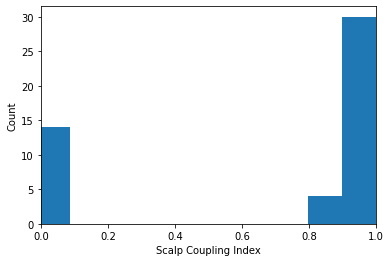

Effective window size : 204.800 (s)
Effective window size : 204.800 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


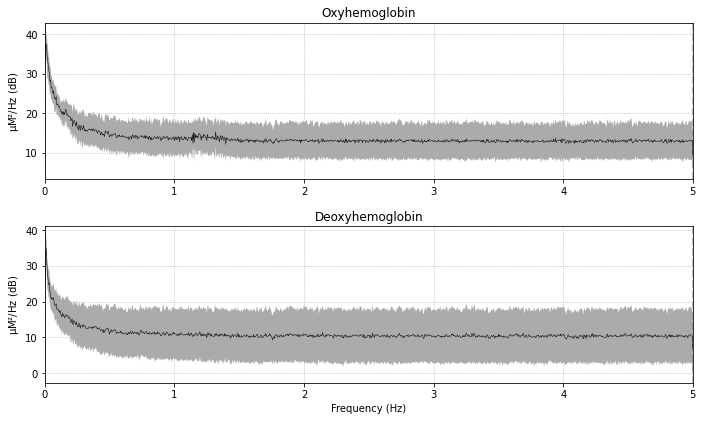

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1651 samples (165.100 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.2s finished


Effective window size : 204.800 (s)
Effective window size : 204.800 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


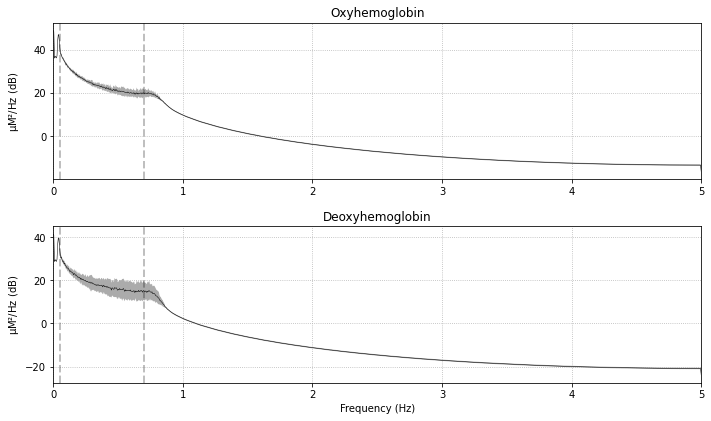

<Info | 10 non-empty values
 bads: 14 items (S2_D2 hbo, S2_D2 hbr, S2_D3 hbo, S2_D3 hbr, S2_D9 hbo, ...)
 ch_names: S1_D1 hbo, S1_D1 hbr, S1_D8 hbo, S1_D8 hbr, S1_D14 hbo, S1_D14 ...
 chs: 24 Oxyhemoglobin, 24 Deoxyhemoglobin
 custom_ref_applied: False
 dig: 51 items (3 Cardinal, 48 EEG)
 highpass: 0.1 Hz
 lowpass: 0.7 Hz
 meas_date: 2021-12-09 10:12:45 UTC
 nchan: 48
 projs: []
 sfreq: 10.0 Hz
 subject_info: 1 item (dict)
>


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


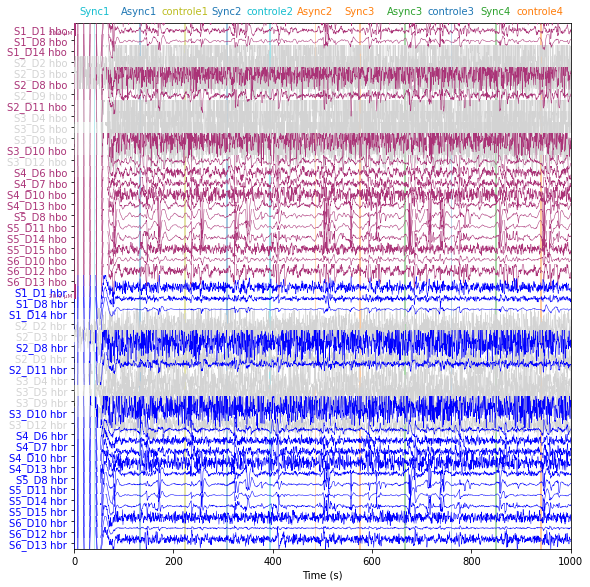

Used Annotations descriptions: ['Async1', 'Async2', 'Async3', 'Async4', 'Async5', 'Async6', 'Async7', 'Async8', 'Sync1', 'Sync2', 'Sync3', 'Sync4', 'Sync5', 'Sync6', 'Sync7', 'Sync8', 'controle1', 'controle2', 'controle3', 'controle4', 'controle5', 'controle6', 'controle7', 'controle8']
Not setting metadata
24 matching events found
Setting baseline interval to [-5.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 24 events and 201 original time points ...
0 bad epochs dropped


<ipython-input-42-f41a60398e4d>:68: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  sfreq=raw_haemo.info['sfreq'])


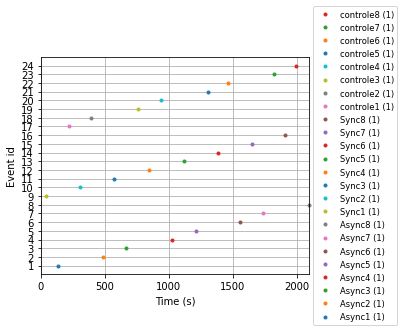

*
* /content/snirf/11_run2.snirf Sync1 X controle1
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


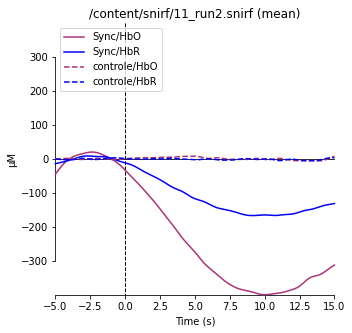

*
* /content/snirf/11_run2.snirf Async1 X controle1
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


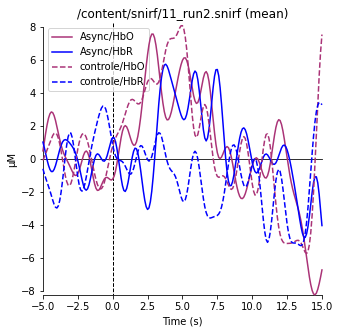

*
* /content/snirf/11_run2.snirf Sync2 X controle2
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


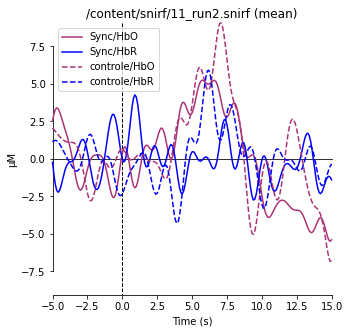

*
* /content/snirf/11_run2.snirf Async2 X controle2
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


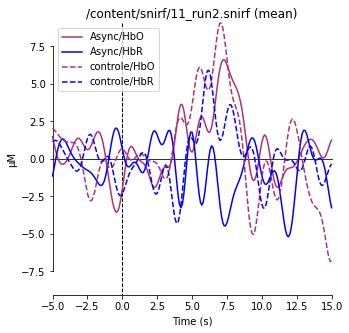

*
* /content/snirf/11_run2.snirf Sync3 X controle3
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


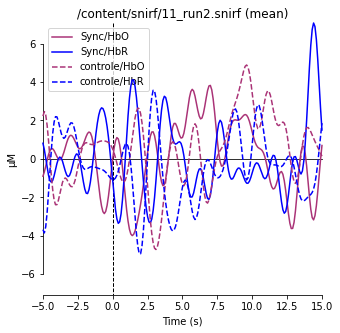

*
* /content/snirf/11_run2.snirf Async3 X controle3
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


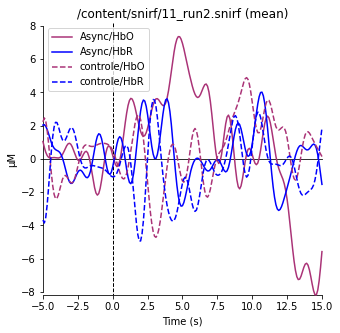

*
* /content/snirf/11_run2.snirf Sync4 X controle4
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


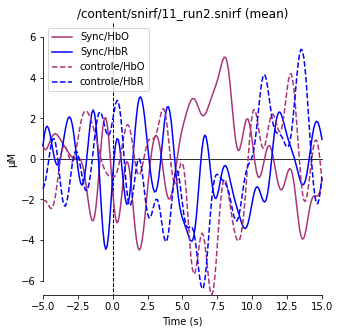

*
* /content/snirf/11_run2.snirf Async4 X controle4
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


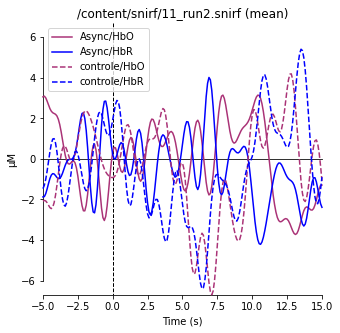

*
* /content/snirf/11_run2.snirf Sync5 X controle5
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


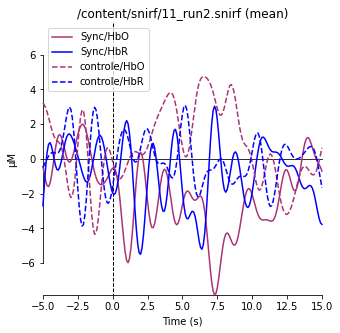

*
* /content/snirf/11_run2.snirf Async5 X controle5
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


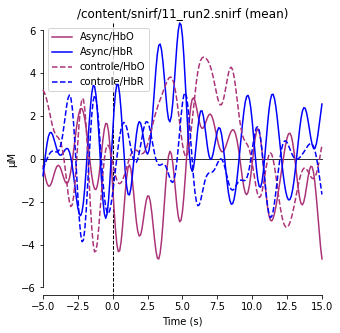

*
* /content/snirf/11_run2.snirf Sync6 X controle6
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


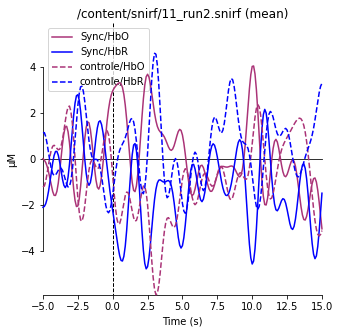

*
* /content/snirf/11_run2.snirf Async6 X controle6
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


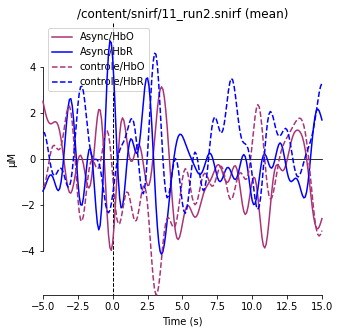

*
* /content/snirf/11_run2.snirf Sync7 X controle7
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


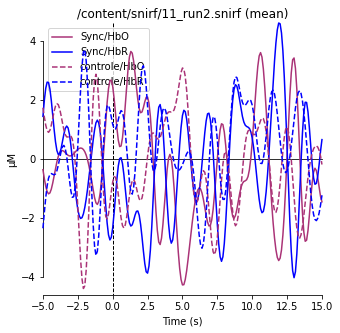

*
* /content/snirf/11_run2.snirf Async7 X controle7
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


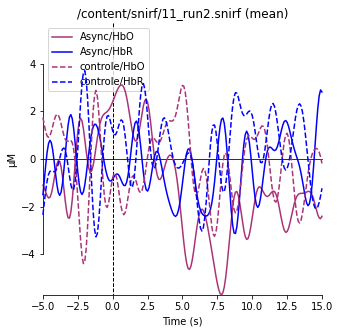

*
* /content/snirf/11_run2.snirf Sync8 X controle8
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


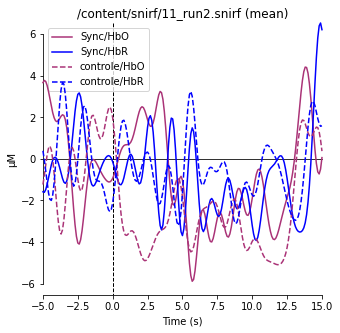

*
* /content/snirf/11_run2.snirf Async8 X controle8
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


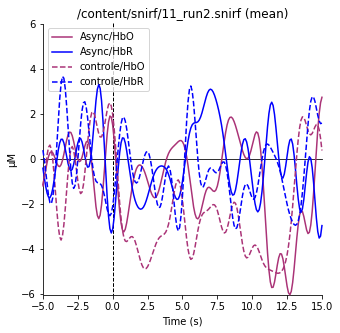

In [ ]:
from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne
import pickle

threshold = 0.60 # FOR bad_list... se você tiver uma trocar!

# entries = [subject + '.snirf']
if condicao == 1:
#  entries_sample = [ entries[4] ]
  entries_sample = [ '38_run1.snirf' ]
else:
  entries_sample = [ entries[1] ]

print(entries_sample)

sci_df_exists = False
sci_df = pd.DataFrame()

for fname in entries_sample:
  raw_intensity = mne.io.read_raw_snirf(path_out + fname, verbose=True)
  raw_intensity.load_data()
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
  sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
  
  fig, ax = plt.subplots()
  ax.hist(sci)
  ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])
  plt.show()
  
  raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < threshold))
  # raw_od.info['bads'] =  bad_list
  raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)

  fig = raw_haemo.plot_psd(average=True)
  fig.suptitle('Before filtering', weight='bold', size='x-large')
  fig.subplots_adjust(top=0.88)
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
                              l_trans_bandwidth=0.02)
  fig = raw_haemo.plot_psd(average=True)
  fig.suptitle('After filtering', weight='bold', size='x-large')
  fig.subplots_adjust(top=0.88)
  plt.show()

  print(raw_haemo.info)

  raw_haemo.plot(n_channels=48, duration=1000, show_scrollbars=False)
  plt.show()

  events, event_dict = mne.events_from_annotations(raw_haemo)

  # events, _ = mne.events_from_annotations(raw_haemo)
  # event_dict = {'Async': 2, 'Sync': 3, 'controle': 4}

  reject_criteria = dict(hbo=80e-6)
  tmin, tmax = -5, 15

  epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                      tmin=tmin, tmax=tmax,
  #                    reject=reject_criteria, reject_by_annotation=True,
                      proj=True, baseline=(None, 0), preload=True,
                      detrend=None, verbose=True,
                      event_repeated='merge') # ADICIONADO Allowed values are 'error', 'drop', and 'merge'
  # epochs.plot_drop_log()

  fig = mne.viz.plot_events(events, event_id=event_dict,
                          sfreq=raw_haemo.info['sfreq'])
  fig.subplots_adjust(right=0.7)  # make room for the legend

  for i in range(8):
    n = str(i+1)
    plt_hemo(raw_haemo=raw_haemo, e1='Sync'+n, c1='controle'+n, e2='Async'+n, c2='controle'+n)


In [ ]:
from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne
import pickle

entries_sample = entries[0:3]
print(entries_sample)

sci_df_exists = False
sci_df = pd.DataFrame()

for fname in entries_sample:
  raw_intensity = mne.io.read_raw_snirf(path_out + fname, verbose=True)
  # raw_intensity = mne.io.read_raw_snirf(path_in + 'snirf/' + fname, verbose=True)
  raw_intensity.load_data()
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
  sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
  
  raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)

  for i in range(len(raw_haemo.annotations[:][:])):
    print(raw_haemo.annotations[:][i]['description'].ljust(15),raw_haemo.annotations[:][i]['onset'])



['10_run2.snirf', '11_run2.snirf', '12_run2.snirf']
Loading /content/snirf/10_run2.snirf
Reading 0 ... 21716  =      0.000 ...  2171.600 secs...


<ipython-input-43-d2845e983d2c>:17: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)


Sync1           40.0
controle1       221.0
Sync2           311.0
controle2       401.0
Sync3           581.0
controle3       761.0
Sync4           851.0
controle4       937.0
Sync5           1122.0
controle5       1304.0
Sync6           1393.0
controle6       1484.0
Sync7           1665.0
controle7       1850.0
Sync8           1940.0
controle8       2089.0
Async1          2171.600098
Loading /content/snirf/11_run2.snirf
Reading 0 ... 21446  =      0.000 ...  2144.600 secs...
Sync1           40.0
Async1          131.0
controle1       222.0
Sync2           306.0
controle2       393.0
Async2          484.0
Sync3           574.0
Async3          665.0
controle3       758.0
Sync4           848.0
controle4       938.0
Async4          1028.0
Sync5           1118.0
Async5          1214.0
controle5       1305.0
Sync6           1385.0
controle6       1465.0
Async6          1556.0
Sync7           1649.0
Async7          1735.0
controle7       1827.0
Sync8           1913.0
controle8       1999.0
Asy

<ipython-input-43-d2845e983d2c>:17: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)


Reading 0 ... 21738  =      0.000 ...  2173.800 secs...


<ipython-input-43-d2845e983d2c>:17: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)


Sync1           40.0
Async1          138.0
controle1       228.0
Sync2           320.0
controle2       411.0
Async2          503.0
Sync3           593.0
Async3          684.0
controle3       775.0
Sync4           866.0
controle4       957.0
Async4          1047.0
Sync5           1136.0
Async5          1228.0
controle5       1319.0
Sync6           1409.0
controle6       1502.0
Async6          1592.0
Sync7           1684.0
Async7          1774.0
controle7       1866.0
Sync8           1954.0
controle8       2044.0
Async8          2135.0


# Copy files para diretório `/snirf` no diretório original

In [ ]:
if not os.path.exists(path_in + 'snirf/'):
  os.mkdir(path_in + 'snirf/')
  print("Directory " , path_in + 'snirf/' ,  "was created")
else:    
  print("Warning: directory " , path_in + 'snirf/' ,  " already exists")

entries = os.listdir(path_out)
out = path_in + 'snirf/'

for f in entries:
  os.system('cp ' + path_out + f + ' ' + "'" + out + f  + "'")

Directory  /content/drive/MyDrive/Cond 2/snirf/ was created
